In [86]:
import tensorflow as tf
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import numpy as np

In [87]:
#DATA COLLECTION #2017-06-08 #2022-06-07
start = pd.to_datetime(['2018-08-08']).astype(int)[0]//10**9 # convert to unix timestamp.
end = pd.to_datetime(['2023-08-09']).astype(int)[0]//10**9 # convert to unix timestamp.
url = 'https://query1.finance.yahoo.com/v7/finance/download/' + 'AMZN' + '?period1=' + str(start) + '&period2=' + str(end) + '&interval=1d&events=history'
df = pd.read_csv(url)

In [88]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1258.000000,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03
mean,123.723335,125.257783,122.056073,123.662120,123.662120,8.208400e+07
std,32.824927,33.123633,32.455461,32.749656,32.749656,3.820701e+07
min,67.300003,69.801498,65.349998,67.197998,67.197998,1.762600e+07
25%,93.533499,94.581877,92.474001,93.492498,93.492498,5.636905e+07
50%,116.659999,118.637501,114.645001,116.345001,116.345001,7.073390e+07
75%,158.346878,159.930752,156.224998,158.093746,158.093746,9.719900e+07
max,187.199997,188.654007,184.839493,186.570496,186.570496,3.113460e+08


In [89]:
dfc=df.reset_index()['Close']
#When we reset the index, the old index is added as a column,
#and a new sequential index is used
dfc.shape

(1258,)

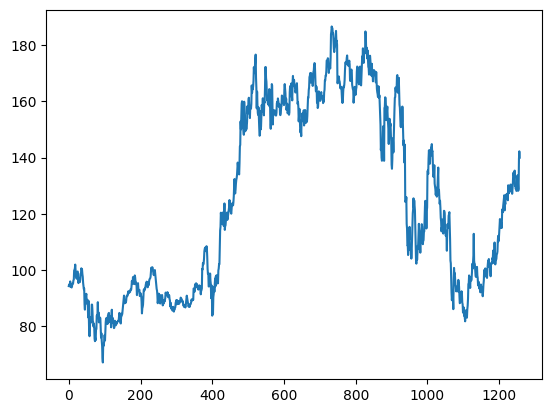

In [90]:
plt.plot(dfc)

In [91]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
dfc=scaler.fit_transform(np.array(dfc).reshape(-1,1)) #Fit to data, then transform it.
#Reshaping to (,1) is needed for fit_transform function

In [92]:
dfc

array([[0.22725501],
       [0.23228135],
       [0.22716291],
       ...,
       [0.60627037],
       [0.62846974],
       [0.60936987]])

In [93]:
#In case of time series data we should always do train-test split in sequential manner because here today's data is dependent on yesterday's data
training_size=int(len(dfc)*0.65)
test_size=len(dfc)-training_size
train_data,test_data=dfc[0:training_size,:],dfc[training_size:len(dfc),:1]
training_size,test_size

(817, 441)

In [94]:
#convert an array of values into a dataset matrix
def datasetmatrix(dataset,time_step=1):
    dataX,dataY=[],[]
    for i in range(len(dataset)-time_step-1):
        a=dataset[i:(i+time_step),0]  ##i=0 , 0,1,2....199 200
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
    return np.array(dataX),np.array(dataY)

In [95]:
#reshape into X=t,t+1,t+2..t+n , Y=t+n+1
time_step=200
X_train,y_train=datasetmatrix(train_data,time_step)
X_test,y_test=datasetmatrix(test_data,time_step)

In [96]:
X_train.shape, y_train.shape,X_test.shape, y_test.shape

((616, 200), (616,), (240, 200), (240,))

In [97]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [98]:
##LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout

In [99]:
model=Sequential()
model.add(LSTM(64, input_shape=(200, 1), return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(64, input_shape=(200, 1), return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(32,kernel_initializer="uniform",activation='relu'))
model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
model.compile(loss='mean_absolute_error',optimizer='adam')

In [100]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 200, 64)           16896     
                                                                 
 dropout_8 (Dropout)         (None, 200, 64)           0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 52,033
Trainable params: 52,033
Non-trai

In [101]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=32,verbose=1)

Epoch 1/100
20/20 [==============================] - 10s 261ms/step - loss: 0.4468 - val_loss: 0.2562
Epoch 2/100
20/20 [==============================] - 5s 227ms/step - loss: 0.2527 - val_loss: 0.2297
Epoch 3/100
20/20 [==============================] - 5s 255ms/step - loss: 0.1281 - val_loss: 0.3854
Epoch 4/100
20/20 [==============================] - 4s 221ms/step - loss: 0.0647 - val_loss: 0.1073
Epoch 5/100
20/20 [==============================] - 5s 271ms/step - loss: 0.0592 - val_loss: 0.0850
Epoch 6/100
20/20 [==============================] - 4s 219ms/step - loss: 0.0544 - val_loss: 0.0747
Epoch 7/100
20/20 [==============================] - 4s 219ms/step - loss: 0.0565 - val_loss: 0.0585
Epoch 8/100
20/20 [==============================] - 5s 271ms/step - loss: 0.0585 - val_loss: 0.0868
Epoch 9/100
20/20 [==============================] - 4s 221ms/step - loss: 0.0654 - val_loss: 0.1204
Epoch 10/100
20/20 [==============================] - 4s 223ms/step - loss: 0.0621 - val_l

In [102]:
model.save(r"AMZN.keras")

In [52]:
trp=model.predict(X_train)
tep=model.predict(X_test)
train_predict=np.array(trp).reshape(-1,)
test_predict=np.array(tep).reshape(-1,)

8/8 [==============================] - 1s 79ms/step


In [20]:
#Performance Metrics
#Training Data
bias=(sum(abs(y_train-train_predict)/y_train)/len(y_train))*100
accuracy=(1-(sum(abs(y_train-train_predict)/y_train)/len(y_train)))*100
print("Train_bias",round(bias,2)),print("Train_acc",round(accuracy,2))
#Testing Data
bias=(sum(abs(y_test-test_predict)/y_test)/len(y_test))*100
accuracy=(1-(sum(abs(y_test-test_predict)/y_test)/len(y_test)))*100
print("Test_bias",round(bias,2)),print("Test_acc",round(accuracy,2))

Train_bias inf
Train_acc -inf
Test_bias 4.31
Test_acc 95.69


<ipython-input-20-ccfa13810394>:3: RuntimeWarning: divide by zero encountered in divide
  bias=(sum(abs(y_train-train_predict)/y_train)/len(y_train))*100
<ipython-input-20-ccfa13810394>:4: RuntimeWarning: divide by zero encountered in divide
  accuracy=(1-(sum(abs(y_train-train_predict)/y_train)/len(y_train)))*100


(None, None)

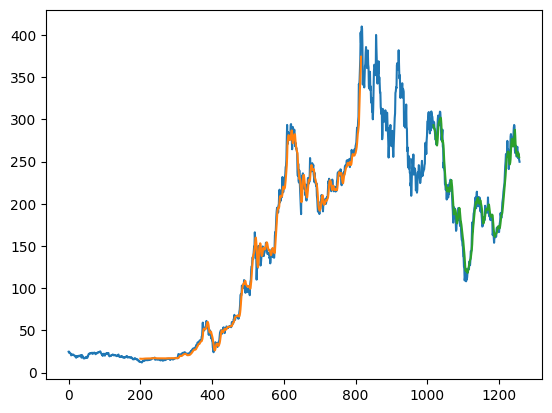

In [21]:
# Plotting
# shift train predictions for plotting
train_predict=trp
test_predict=tep
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
back=200
trainpredictplt=np.empty_like(dfc)
trainpredictplt[:,:]=np.nan
trainpredictplt[back:len(train_predict)+back,:]=train_predict
# shift test predictions for plotting
testpredictplt=np.empty_like(dfc)
testpredictplt[:,:]=np.nan
testpredictplt[len(train_predict)+(back*2)+1:len(dfc)-1,:]=test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dfc))
plt.plot(trainpredictplt)
plt.plot(testpredictplt)
plt.show()

In [22]:
len(test_data)

441

In [23]:
x_input=test_data[241:].reshape(1,-1)
x_input.shape

(1, 200)

In [24]:
temp_list=list(x_input)
temp_list=temp_list[0].tolist()

In [25]:
len(temp_list)

200

In [26]:
# Next 50 days prediction
from numpy import array
lst_output=[]
n_steps=200
i=0
while(i<50):

    if(len(temp_list)>200):
        x_input=np.array(temp_list[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input=x_input.reshape((1,n_steps,1))
        yhat=model.predict(x_input,verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_list.extend(yhat[0].tolist())
        temp_list=temp_list[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input=x_input.reshape((-1,n_steps,1))
        yhat=model.predict(x_input,verbose=0)
        print(yhat[0])
        temp_list.extend(yhat[0].tolist())
        print(len(temp_list))
        lst_output.extend(yhat.tolist())
        i=i+1


print(lst_output)

[0.597279]
201
1 day input [0.50876632 0.50075202 0.52881462 0.53439197 0.5355225  0.54413977
 0.54167767 0.54238116 0.51012296 0.51095203 0.49125546 0.46515247
 0.45063127 0.41618736 0.44917412 0.46236379 0.44975194 0.45846969
 0.4396273  0.43020611 0.42271941 0.39176762 0.39689277 0.43028147
 0.42942729 0.42957803 0.42432729 0.45917314 0.45917314 0.45957512
 0.42839723 0.42178986 0.40726862 0.40576125 0.41985536 0.39164204
 0.37438238 0.36395627 0.36614198 0.34745032 0.34654588 0.31622222
 0.31564439 0.28494384 0.27941675 0.24411866 0.25318813 0.27607536
 0.27949211 0.24160634 0.25552459 0.24723393 0.25406744 0.2709251
 0.26861376 0.2795926  0.28044679 0.27753251 0.30036949 0.29356109
 0.28951626 0.30521825 0.33117051 0.33152223 0.33287886 0.37267402
 0.41696618 0.38872774 0.40520854 0.42578444 0.44301895 0.44731499
 0.45932387 0.46447413 0.47572931 0.49087862 0.46467512 0.4590224
 0.49572738 0.50826387 0.47761355 0.4933658  0.46588102 0.47464903
 0.47768895 0.46465001 0.49165744 0.4

In [27]:
days_200=np.arange(1,201)
days_pred=np.arange(201,251)

In [28]:
len(dfc)

1258

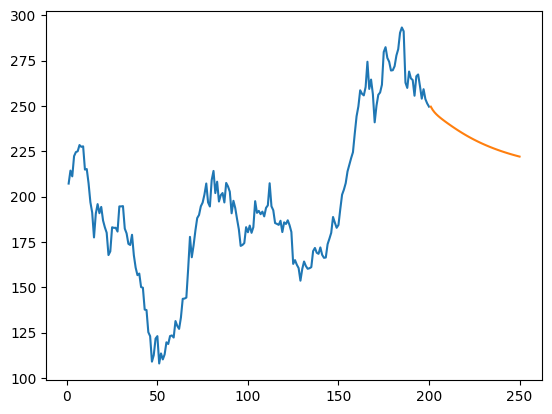

In [29]:
plt.plot(days_200,scaler.inverse_transform(dfc[1058:]))
plt.plot(days_pred,scaler.inverse_transform(lst_output))

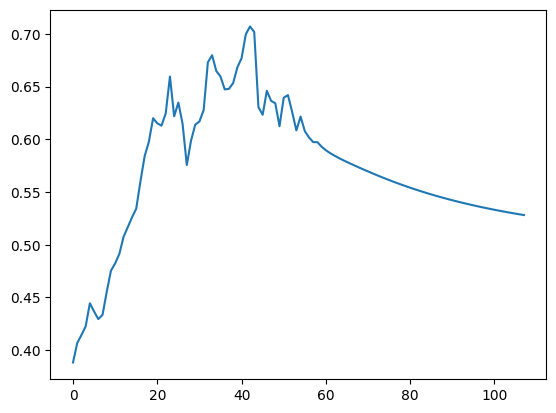

In [30]:
df2=dfc.tolist()
df2.extend(lst_output)
plt.plot(df2[1200:])

In [31]:
df2=scaler.inverse_transform(df2).tolist()

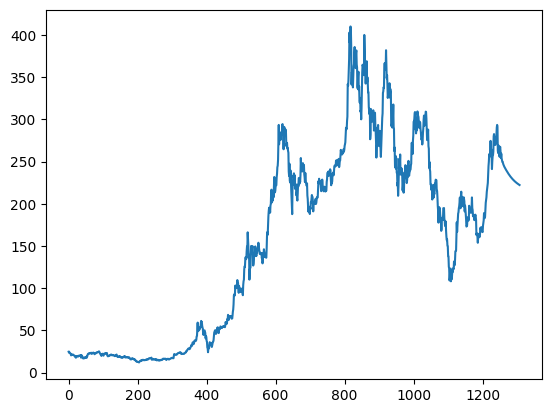

In [32]:
plt.plot(df2)